## Random Forest Classifier: cross-validation and hyper-parameter tuning

**Input**: Bronze standard set of pairs + paralog pair annotations

Train model with all features + tune hyper-parameters using cross-validation.

In [119]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%load_ext autoreload
%autoreload 1
%aimport graphing_params

import itertools
import os, sys

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_depmap_pairs = get_local_data_path(['results'], 'bronze_standard_SL_pairs.csv')
file_features = get_local_data_path([], 'feature_list.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [120]:
paralog_annotations = pd.read_csv(file_annot_pairs)
print('Num annotated pairs:', paralog_annotations.shape[0])
depmap_pairs = pd.read_csv(file_depmap_pairs)
depmap_pairs = pd.merge(depmap_pairs, paralog_annotations)
print('Num SL:', depmap_pairs[depmap_pairs.SL].shape[0], '/', depmap_pairs.shape[0])
depmap_pairs[:2]

Num annotated pairs: 36648
Num SL: 126 / 3634


,A1,A2,SL,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,AAK1,BMP2K,False,ENSG00000115977,ENSG00000138756,22848,55589,True,0.341947,0.413111,...,True,False,False,True,False,False,7,976.25,0.0,False
1,ABCA1,ABCA7,False,ENSG00000165029,ENSG00000064687,19,10347,False,0.498894,0.525629,...,False,False,False,False,False,False,5,4200.00,0.0,False


In [121]:
features_list = pd.read_csv(file_features)
features = list(features_list[features_list.include==1].feature)
print('N features', len(features))
print(features)

N features 22
['min_sequence_identity', 'closest', 'WGD', 'family_size', 'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog', 'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog', 'has_essential_cerevisiae_ortholog', 'conservation_score', 'mean_age', 'either_in_complex', 'mean_complex_essentiality', 'colocalisation', 'interact', 'n_total_ppi', 'fet_ppi_overlap', 'shared_ppi_mean_essentiality', 'gtex_spearman_corr', 'gtex_min_mean_expr', 'gtex_max_mean_expr']


### Grid Search for Hyper-Parameters
Want a model that is as general/conservative as possible - relatively low depth, relatively high number of samples per leaf.  
Goal is to identify broad trends for SL pairs.

In [123]:
param_grid = {
    'max_depth': [3,4],
    'min_samples_leaf':[7,8,9,10,11,12],
    'max_features':[10,11,12,13]
}
RF = RandomForestClassifier(n_estimators=600, random_state=8, n_jobs=-1)
gsearch = GridSearchCV(RF, scoring='average_precision', return_train_score=True, param_grid=param_grid,
                        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=3))
gsearch.fit(depmap_pairs[features], depmap_pairs.SL)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=3, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=600, n_jobs=-1,
                                              random_state=8),
             param_grid={'max_depth': [3, 4], 'max_features': [10, 11, 12, 13],
                         'min_samples_leaf': [7, 8, 9, 10, 11, 12]},
             return_train_score=True, scoring='average_precision')

In [124]:
def compile_gsearch_results(gsearch):
        gsearch_results = pd.DataFrame()
        for col in ['mean_test_score', 'mean_train_score', 'param_max_depth', 'param_min_samples_leaf', 'param_max_features']:
                gsearch_results[col] = gsearch.cv_results_[col]
        return gsearch_results

gsearch_results = compile_gsearch_results(gsearch)

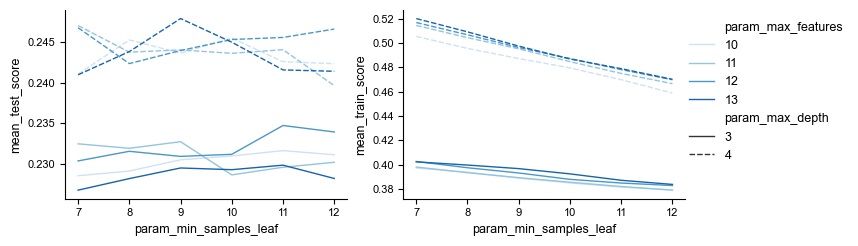

In [125]:
f, ax = plt.subplots(1, 2, figsize=(8,2.5))
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', hue='param_max_features', style='param_max_depth',
             data=gsearch_results, ax=ax[0], palette=sns.color_palette("Blues", 4))
sns.lineplot(x='param_min_samples_leaf', y='mean_train_score', hue='param_max_features', style='param_max_depth', 
             data=gsearch_results, ax=ax[1],palette=sns.color_palette("Blues", 4))
ax[0].legend().remove()
ax[1].legend(loc='upper right', bbox_to_anchor=(1.6,1))

### Random Forest CV with Training Data

In [128]:
def run_cross_validation(classifier, X, y, nfolds=4):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    aucs = []
    seq_aucs = []
    
    y_real = []
    y_proba = []
    aps = []
    seq_aps = []
    
    k_fold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=3)
    
    for train, test in k_fold.split(X, y):
        ypred = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, _ = roc_curve(y.iloc[test], ypred[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc_score(y.iloc[test], ypred[:, 1]))
        seq_aucs.append(roc_auc_score(y.iloc[test], X.iloc[test].min_sequence_identity))
        
        aps.append(average_precision_score(y.iloc[test], ypred[:, 1]))
        seq_aps.append(average_precision_score(y.iloc[test], X.iloc[test].min_sequence_identity))
        y_real.append(y.iloc[test].values)
        y_proba.append(ypred[:, 1])
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Concatenate all the arrays into 1 array
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    
    return {'tpr':mean_tpr, 'fpr':mean_fpr, 'auc':mean_auc, 'std_auc':std_auc, 
            'seq_auc':np.mean(seq_aucs), 'seq_std_auc':np.std(seq_aucs),
            'precision':precision, 'recall':recall, 'ap':np.mean(aps), 'std_ap':np.std(aps),
            'seq_ap':np.mean(seq_aps), 'seq_std_ap':np.std(seq_aps)}

In [129]:
def draw_cv_roc_curve(cv_results, ax, label, color="black"):    
    ax.step(cv_results['fpr'], cv_results['tpr'], 
            label=label+'(%.2f $\pm$%.2f)' % (cv_results['auc'], cv_results['std_auc']), color=color, zorder=10)

    ax.set_xlim([-0.05, 1.02])
    ax.set_ylim([-0.05, 1.02])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
def draw_cv_pr_curve(cv_results, ax, label, color="black"):
    line_kwargs = {"drawstyle": "steps-post"}
    precision = cv_results['precision'][:-1]; recall = cv_results['recall'][:-1]
    ax.step(recall, precision, label=label+'(%.2f $\pm$%.2f)' % (cv_results['ap'], cv_results['std_ap']), 
            color=color, zorder=10, **line_kwargs)

    ax.set_xlim([-0.05, 1.02])
    ax.set_ylim([-0.05, 1.02])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
def draw_seq_id_curves(axes, cv_results, data):
    fpr, tpr, _ = roc_curve(data.SL, data.min_sequence_identity)
    ax[0].step(fpr, tpr, label='Seq. Id. (%.2f $\pm$%.2f)' % (cv_results['seq_auc'], cv_results['seq_std_auc']), 
               color='#E69F00')
    
    precision, recall, _ = precision_recall_curve(data.SL, data.min_sequence_identity)
    recall = recall[:-1]; precision = precision[:-1]
    line_kwargs = {"drawstyle": "steps-post"}
    ax[1].plot(recall, precision, label='Seq. Id. (%.2f $\pm$%.2f)' % (cv_results['seq_ap'], cv_results['seq_std_ap']), 
               color='#E69F00', **line_kwargs)
    
def draw_chance_lines(axes, data):
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='black', label='Chance (0.50)')
    no_skill = sum(data.SL) / (data.SL).count()
    axes[1].plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='Chance (%.2f)' % (no_skill))
    axes[0].legend(loc='lower right', bbox_to_anchor=(1.05,0))
    axes[1].legend()

In [138]:
RF = RandomForestClassifier(n_estimators=600, random_state=8, max_features=11, max_depth=3, min_samples_leaf=8)
cv_results = run_cross_validation(RF, depmap_pairs[features], depmap_pairs.SL)

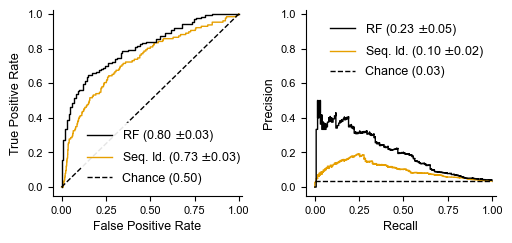

In [139]:
f, ax = plt.subplots(1, 2, figsize=(5.2,2.5))
draw_cv_roc_curve(cv_results, ax[0], label='RF ')
draw_cv_pr_curve(cv_results, ax[1], label='RF ')
draw_seq_id_curves(ax, cv_results, depmap_pairs)
draw_chance_lines(ax, depmap_pairs)
plt.tight_layout()
#plt.savefig("../figures/for_paper/RF_curves.svg", bbox_inches="tight", dpi=300)

In [140]:
# Find recall at which precision is above 35-40%
idx = np.where(cv_results['precision'] > 0.35)
print('Max recall where precision is >35%:', np.max(cv_results['recall'][idx]))
idx = np.where(cv_results['precision'] > 0.4)
print('Max recall where precision is >40%:', np.max(cv_results['recall'][idx]))

Max recall where precision is >35%: 0.21428571428571427
Max recall where precision is >40%: 0.19047619047619047
